# LangGraph : Custom AgenticRAG

- Retrieval agents are useful when you want an LLM to make a decision about whether to retrieve context from a vectorstore or respond to the user directly. VectorDB is considered as the tool, LLM is the decision maker wether to call the RAG or not.
- https://docs.langchain.com/oss/python/langgraph/agentic-rag
- https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_crag/
- https://smith.langchain.com/hub --> Prompts repository


## Environment

In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage, SystemMessage
from langgraph.graph import StateGraph

/Users/chandra/Courses/DataScience/NLP/AgenticAI/agenticaienv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
from dotenv import load_dotenv
load_dotenv() # you can pass the absolute path to .env file

#store keys in the OS env
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

## Langsmith Tracking And Tracing
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]="AgentiAICourse_01"
os.environ["LANGCHAIN_TRACING_V2"]="true"

## Setup Vector Store

### Load the documents from the web

In [3]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for urldocs in docs for item in urldocs ]

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
docs_list[0].page_content.strip()[1000:1500]

'System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nSh'

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=250,chunk_overlap=50)
doc_splitted=text_splitter.split_documents(docs_list)
doc_splitted[4].page_content.strip()

'Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of domain-specific PDDL and a suitable planner which is common in certain robotic setups but not in many other domains.\nSelf-Reflection#'

#### Retriver with In Memrory Vecot Store and Open AI Embeddings

In [6]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings
vector_store=InMemoryVectorStore.from_documents(documents=doc_splitted,embedding=OpenAIEmbeddings())
retriever=vector_store.as_retriever()

## LLM Powered Agentic RAG


- Create Tool to retrive the documents from vector store
- Create LLM powered router to decide whether to call tool or end process.
- Create LLM powered function whether fetched documents are still relavant or not by grading them
- Create LLM powered function to rewrite the question
- Create LLM to generate the output and end flow



#### Tool

In [ ]:
from langgraph.graph import MessagesState
chat_model=ChatOpenAI(model="gpt-4o", temperature=0)

In [8]:
from langchain.tools import tool

@tool
def retrieve_tool(query:str) -> str:
    """search and return information from Lilian Weng blog posts"""
    retrieved_docs=retriever.invoke(query)
    return "\n\n".join([doc.page_content for doc in retrieved_docs])

retrieve_tool = retrieve_tool
retrieve_tool.invoke({"query": "LLM Hallucinations"})

'Weng, Lilian. (Jul 2024). Extrinsic Hallucinations in LLMs. Lil’Log. https://lilianweng.github.io/posts/2024-07-07-hallucination/.\n\nExtrinsic Hallucinations in LLMs | Lil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      Extrinsic Hallucinations in LLMs\n    \nDate: July 7, 2024  |  Estimated Reading Time: 29 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nWhat Causes Hallucinations?\n\nPre-training Data Issues\n\nFine-tuning New Knowledge\n\n\nHallucination Detection\n\nRetrieval-Augmented Evaluation\n\nSampling-Based Detection\n\nCalibration of Unknown Knowledge\n\nIndirect Query\n\n\nAnti-Hallucination Methods\n\nRAG → Edits and Attribution\n\nChain of Actions\n\nSampling Methods\n\nFine-tuning for Factuality\n\nFine-tuning for Attribution\n\n\nAppendix: Evaluation Benchmarks\n\nCit

#### LLM Router

In [9]:
def generate_query_or_respond(state:MessagesState):
    """Call the LLM model to generate a response based on the current state and 
    decide whether to call retriever or respond to user
    """
    response = chat_model.bind_tools([retrieve_tool]).invoke(state["messages"])

    return {"messages": [response]}


In [10]:
#Test
# input = {"messages": [{"role": "user", "content": "hello!"}]}
# generate_query_or_respond(input)["messages"][-1].pretty_print()

In [11]:
#Ask a question with semantic search
# input = {
#     "messages": [
#         {
#             "role": "user",
#             "content": "What does Lilian Weng say about types of reward hacking?",
#         }
#     ]
# }
# generate_query_or_respond(input)["messages"][-1].pretty_print()

#### Grade Documents

In [12]:
from pydantic import BaseModel,Field
from typing import Literal

class GradeDocuments(BaseModel):  
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relavant"
    )

def grade_documents(state:MessagesState)-> Literal["generate_answer","rewrite_question"]:
    """
    Determine whether retrieved documetns are relevant or not
    """
    GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
    )
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt= GRADE_PROMPT.format(question=question,context=context)
    response = chat_model.with_structured_output(GradeDocuments).invoke([{"role":"user","content":prompt}])

    # repoonse has the output variable binary score.
    if response.binary_score.lower()=='yes':
        return "generate_answer"
    else:
        return "rewrite_question"



In [13]:
# from langchain_core.messages import convert_to_messages

# input = {
#     "messages": convert_to_messages(
#         [
#             {
#                 "role": "user",
#                 "content": "What does Lilian Weng say about Hallucinations in LLMs?",
#             },
#             {
#                 "role": "assistant",
#                 "content": "",
#                 "tool_calls": [
#                     {
#                         "id": "1",
#                         "name": "retrive_context_from_blogs",
#                         "args": {"query": "Hallucinations in LLMs"},
#                     }
#                 ],
#             },
#             {"role": "tool", "content": "meow", "tool_call_id": "1"},
#         ]
#     )
# }
# grade_documents(input)

#### Reqwrite the question

In [14]:
# Function to rewrite the question.

def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)

    prompt = REWRITE_PROMPT.format(question=question)
    response = chat_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [HumanMessage(content=response.content)]}


In [15]:
# #TEST
# input = {
#     "messages": convert_to_messages(
#         [
#             {
#                 "role": "user",
#                 "content": "What does Lilian Weng say about types of reward hacking?",
#             },
#             {
#                 "role": "assistant",
#                 "content": "",
#                 "tool_calls": [
#                     {
#                         "id": "1",
#                         "name": "retrieve_blog_posts",
#                         "args": {"query": "types of reward hacking"},
#                     }
#                 ],
#             },
#             {"role": "tool", "content": "meow", "tool_call_id": "1"},
#         ]
#     )
# }

# response = rewrite_question(input)
# print(response["messages"][-1].content)

#### Generate the answer

In [16]:
def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)

    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = chat_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

#### Custom RAG Agent

- Start with a generate_query_or_respond and determine if we need to call retriever_tool
- Route to next step using tools_condition:
    - If generate_query_or_respond returned tool_calls, call retriever_tool to retrieve context
    - Otherwise, respond directly to the user
- Grade retrieved document content for relevance to the question (grade_documents) and route to next step:
    - If not relevant, rewrite the question using rewrite_question and then call generate_query_or_respond again
    - If relevant, proceed to generate_answer and generate final response using the ToolMessage with the retrieved document context

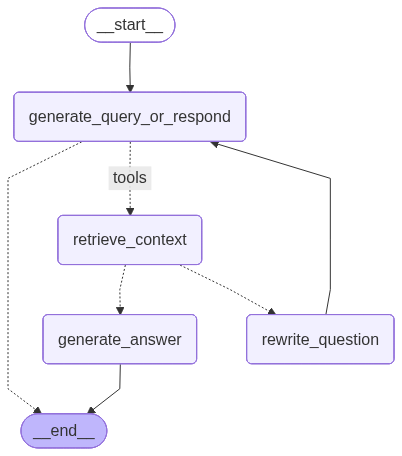

In [17]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

workflow=StateGraph(MessagesState)

#define Nodes
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve_context",ToolNode([retrieve_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

#add edges
workflow.add_edge(START,"generate_query_or_respond")
workflow.add_conditional_edges("generate_query_or_respond",tools_condition,{"tools":"retrieve_context", END:END})
workflow.add_conditional_edges("retrieve_context", grade_documents) # this returns the generate_answer or rewrite_question
workflow.add_edge("rewrite_question","generate_query_or_respond")
workflow.add_edge("generate_answer",END)

crag_agent=workflow.compile()

from IPython.display import Image, display
display(Image(crag_agent.get_graph().draw_mermaid_png()))

In [22]:
query={"messages": [
            {
                "role": "user",
                "content": "What is security protocol ?"
                }
        ]
    }

crag_agent.invoke(query)

{'messages': [HumanMessage(content='What is security protocol ?', additional_kwargs={}, response_metadata={}, id='669b3ac0-860e-4fd6-ac87-e4e4ba0854fe'),
  AIMessage(content='A security protocol is a set of rules and conventions that dictate how data is transmitted and secured over a network. These protocols are designed to protect data integrity, confidentiality, and authenticity during communication between devices. Security protocols use various cryptographic techniques to ensure that data is not intercepted, altered, or accessed by unauthorized parties.\n\nSome common examples of security protocols include:\n\n1. **SSL/TLS (Secure Sockets Layer/Transport Layer Security):** Used to secure data transmitted over the internet, particularly in web browsing, email, and instant messaging.\n\n2. **IPsec (Internet Protocol Security):** A suite of protocols used to secure Internet Protocol (IP) communications by authenticating and encrypting each IP packet in a communication session.\n\n3. *